In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim as gm
import nltk
from nltk.corpus import stopwords
import re 
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#nltk.download('punkt')

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
page = 1

authors_lst = []
quotes_lst = []
tags_lst = []


while page < 11: 
    url = 'http://quotes.toscrape.com/page/{}'.format(page)
    scrape = requests.get(url)
    parsed = BeautifulSoup(scrape.content, "html.parser")
    
    curr_authors = list(map(lambda x: x.text, parsed.find_all(class_ = "author")))
    curr_quotes = list(map(lambda x: x.text, parsed.find_all(class_ = 'text')))
    
    tag_groups = parsed.find_all("div", class_ = "tags")

    curr_tags = []
    for i in range(len(tag_groups)):

        tags = tag_groups[i].find_all("a", class_ = "tag")

        curr_group = []
        for tag in tags:

            curr_group.append(tag.text)

        curr_tags.append(curr_group)
    
    authors_lst += curr_authors
    quotes_lst += curr_quotes
    tags_lst += curr_tags
    
    page += 1
    
data = {"Author":authors_lst, "Quote":quotes_lst, "Tags":tags_lst}
df = pd.DataFrame(data)

In [4]:
def quotes_cleaning(text):
    
    text = text.lower()
    
    text = re.sub('[^A-Za-z\s]', '', text)
    
    return text

df['Quote'] = df['Quote'].apply(quotes_cleaning)
df['Author'] = df['Author'].apply(quotes_cleaning)

In [5]:
def tags_cleaning(text):
    
    if len(text) == 0:
        
        return []
    
    text = re.sub('[\[ \]]', ' ', str(text))
    text = re.sub('[^\w]', ' ', text)
    text = re.sub('[\s]', ' ', text)
    
    text = ' '.join(text.split())
    
    return text.split(' ')

df['Tags'] = df['Tags'].apply(tags_cleaning)

In [6]:
df.head(3)

Author                                              Quote  \
0  albert einstein  the world as we have created it is a process o...   
1       jk rowling  it is our choices harry that show what we trul...   
2  albert einstein  there are only two ways to live your life one ...   

                                             Tags  
0       [change, deep, thoughts, thinking, world]  
1                            [abilities, choices]  
2  [inspirational, life, live, miracle, miracles]

In [7]:
df['Tags'].apply(lambda x: len(x)).min()

0

In [8]:
def tag_to_column(tags):
    
    sub = 11 - len(tags)
        
    total = tags + [None] * sub
    return total

In [9]:
column_renames = {0:'tag_1',1:'tag_2',2:'tag_3',3:'tag_4',4:'tag_5',5:'tag_6',6:'tag_7',7:'tag_8',8:'tag_9',9:'tag_10', 10:'tag_11',}

tags = pd.DataFrame(df['Tags'].apply(tag_to_column).tolist()).rename(columns = column_renames)

tags_df = pd.get_dummies(tags, prefix = 'tag')
combined = pd.concat([df, tags_df], axis = 1).drop(columns = ['Tags'])
combined.head(3)

Author                                              Quote  \
0  albert einstein  the world as we have created it is a process o...   
1       jk rowling  it is our choices harry that show what we trul...   
2  albert einstein  there are only two ways to live your life one ...   

   tag_abilities  tag_activism  tag_adulthood  tag_adventure  tag_age  \
0              0             0              0              0        0   
1              1             0              0              0        0   
2              0             0              0              0        0   

   tag_alcohol  tag_aliteracy  tag_attributed  ...  tag_plans  tag_truth  \
0            0              0               0  ...          0          0   
1            0              0               0  ...          0          0   
2            0              0               0  ...          0          0   

   tag_writers  tag_love  tag_peace  tag_philosophy  tag_writing  \
0            0         0          0               0            0   
1            0         0          0               0            0   
2            0         0          0               0            0   

   tag_marriage  tag_unhappy  tag_marriage  
0             0            0             0  
1             0            0             0  
2             0            0             0  

[3 rows x 200 columns]

<AxesSubplot:>

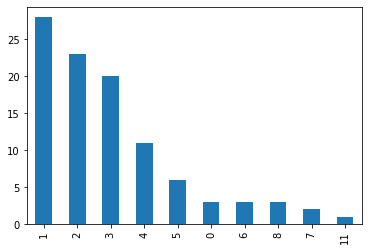

In [10]:
rowsums = combined.iloc[:,2:].sum(axis=1)
cnt = rowsums.value_counts()

cnt.plot(kind = 'bar')

In [11]:
categories = combined.columns.tolist()[2:]

train, test = train_test_split(combined, random_state=42, test_size=0.33, shuffle=True)

X_train = train.Quote
X_test = test.Quote

print(X_train.shape)
print(X_test.shape)

(67,)
(33,)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing tag_abilities
Test accuracy is 1.0
... Processing tag_activism
Test accuracy is 1.0
... Processing tag_adulthood
Test accuracy is 1.0
... Processing tag_adventure
Test accuracy is 1.0
... Processing tag_age
Test accuracy is 0.9696969696969697
... Processing tag_alcohol
Test accuracy is 1.0
... Processing tag_aliteracy
Test accuracy is 1.0
... Processing tag_attributed
Test accuracy is 0.9696969696969697
... Processing tag_authors
Test accuracy is 1.0
... Processing tag_be
Test accuracy is 0.9696969696969697
... Processing tag_beatles
Test accuracy is 0.9696969696969697
... Processing tag_better
Test accuracy is 1.0
... Processing tag_bilbo
Test accuracy is 1.0
... Processing tag_books
Test accuracy is 0.8787878787878788
... Processing tag_change
Test accuracy is 0.9696969696969697
... Processing tag_children
Test accuracy is 0.9393939393939394
... Processing tag_chocolate
Test accuracy is 1.0
... Processing tag_christianity
Test accuracy is 1.0
... Processing tag_comedy


Test accuracy is 0.9090909090909091
... Processing tag_s
Test accuracy is 1.0
... Processing tag_sun
Test accuracy is 1.0
... Processing tag_tea
Test accuracy is 1.0
... Processing tag_teresa
Test accuracy is 0.9696969696969697
... Processing tag_thinking
Test accuracy is 0.9393939393939394
... Processing tag_truth
Test accuracy is 0.9393939393939394
... Processing tag_up
Test accuracy is 0.9696969696969697
... Processing tag_wisdom
Test accuracy is 1.0
... Processing tag_women
Test accuracy is 1.0
... Processing tag_books
Test accuracy is 0.8787878787878788
... Processing tag_dreams
Test accuracy is 0.9696969696969697
... Processing tag_inspirational
Test accuracy is 0.8484848484848485
... Processing tag_lack
Test accuracy is 1.0
... Processing tag_lennon
Test accuracy is 1.0
... Processing tag_lewis
Test accuracy is 1.0
... Processing tag_life
Test accuracy is 0.8787878787878788
... Processing tag_love
Test accuracy is 0.9090909090909091
... Processing tag_miracles
Test accuracy is 1

In [18]:
NB_pipeline.fit(X_train, train['tag_books'])
NB_pipeline.predict(X_test)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])